## Privacy preserving data analysis and diagnosis

This application will receive a Medical dataset with both medical and personal information about patients. This data include:
- Name
- Age
- Gender
- Telephone
- BMI
- Heart Pressure

We want to process this data in a secure manner, to comply with Privacy Policies, while being able to diagnose the patients.

### 1. Import libraries and set the Context
We will use heaan for encryption and pandas for working with datasets.

In [ ]:
import pandas as pd
import numpy as np
import heaan_stat 
# init context
context = heaan_stat.Context(
    key_dir_path='./keys',
    generate_keys=True,  # To use existing keys, set it to False or omit this
)

The dataset used is imported from Kaggle: https://www.kaggle.com/datasets/oktayrdeki/heart-disease 

In [2]:
df = pd.read_csv('heart.csv')
# Check structure of the DataFrame
print(df.columns)

Index(['Age', 'Gender', 'Blood Pressure', 'Cholesterol Level',
       'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'BMI',
       'High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol',
       'Alcohol Consumption', 'Stress Level', 'Sleep Hours',
       'Sugar Consumption', 'Triglyceride Level', 'Fasting Blood Sugar',
       'CRP Level', 'Homocysteine Level', 'Heart Disease Status', 'Name',
       'Telephone'],
      dtype='object')


### 2. Preprocess the Data
After checking the columns of our dataset, we decide the ones we want to keep. Since some are Categorical, we must set the type as category.

In [3]:
attributes = ["Age", "Gender", "Blood Pressure", "Cholesterol Level", "BMI", "Heart Disease Status"]
df_heart = df[attributes]
df_heart["Gender"] = df_heart["Gender"].astype('category')
df_heart["Heart Disease Status"] = df_heart["Heart Disease Status"].astype('category')


/tmp/ipykernel_19304/2675493866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_heart["Gender"] = df_heart["Gender"].astype('category')
/tmp/ipykernel_19304/2675493866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_heart["Heart Disease Status"] = df_heart["Heart Disease Status"].astype('category')


### 3. Encryption
Now that we have our dataset preprocessed and cut down, we can encrypt it using our HE Context. 

In [11]:
from heaan_stat import HEFrame
hf = HEFrame(context, df_heart, encrypt_columns=True)
print(hf.info())

<class 'heaan_stat.frame.public.he_frame.HEFrame'>
Data rows: 10000
Data columns (total 6 columns):
#    Column                    Dtype      Encrypted 
---  ------------------------  ---------  ----------
  0  Age                       numeric    True      
  1  BMI                       numeric    True      
  2  Blood Pressure            numeric    True      
  3  Cholesterol Level         numeric    True      
  4  Gender                    category   True      
  5  Heart Disease Status      category   True      
dtypes: numeric(4), category(2)


This is our encrypted dataset. We can access individual columns (returned as HESeries) and even decrypt them, without decrypting the entire dataset. This way we can check some patients information without revealing all their data.

In [15]:
hf['Age'].decrypt(inplace=True)
hf['Gender'].decrypt(inplace=True)
print(hf.info())

<class 'heaan_stat.frame.public.he_frame.HEFrame'>
Data rows: 10000
Data columns (total 6 columns):
#    Column                    Dtype      Encrypted 
---  ------------------------  ---------  ----------
  0  Age                       numeric    False     
  1  BMI                       numeric    True      
  2  Blood Pressure            numeric    True      
  3  Cholesterol Level         numeric    True      
  4  Gender                    category   False     
  5  Heart Disease Status      category   True      
dtypes: numeric(4), category(2)


### 4. Statistical Operations
Our dataset contains data related to the presence/absence of Heart Disease. 
We can perform statistical operations on the encrypted data to obtain some information 
about how these attributes correlate to the disease.
First, we will take a smaller sample of the data (for performance)

In [6]:
sample_df = df_heart[0:100]
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Age                   100 non-null    float64 
 1   Gender                100 non-null    category
 2   Blood Pressure        99 non-null     float64 
 3   Cholesterol Level     100 non-null    float64 
 4   BMI                   100 non-null    float64 
 5   Heart Disease Status  100 non-null    category
dtypes: category(2), float64(4)
memory usage: 3.7 KB


And of course we encrypt it

In [16]:
hf_sample = HEFrame(context, sample_df, encrypt_columns=True)
print(hf_sample.info())

<class 'heaan_stat.frame.public.he_frame.HEFrame'>
Data rows: 100
Data columns (total 6 columns):
#    Column                    Dtype      Encrypted 
---  ------------------------  ---------  ----------
  0  Age                       numeric    True      
  1  BMI                       numeric    True      
  2  Blood Pressure            numeric    True      
  3  Cholesterol Level         numeric    True      
  4  Gender                    category   True      
  5  Heart Disease Status      category   True      
dtypes: numeric(4), category(2)


With the encrypted sample dataset, we can group by the Gender category.
Having the dataset grouped, we can calculate the mean values of different attributes.
We then decrypt this mean value and we can plot it to compare it, all without having to access
the decrypted data.

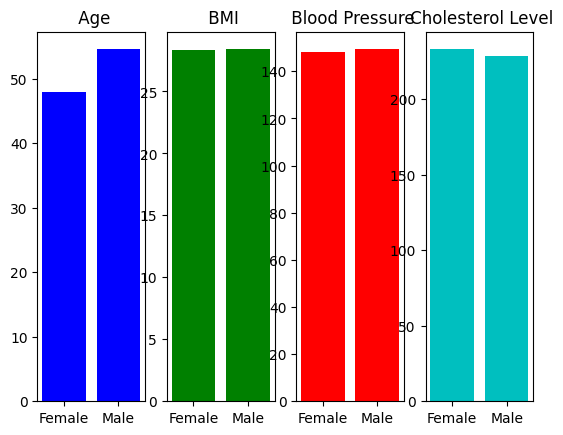

In [8]:
hg = hf_sample.groupby('Gender')
mean = hg.mean()
mean.decrypt(inplace=True)
mean.plot()

### Find most relevant risk factors

Using statistical tools like correlation and covariance, analysis of the data could be performed to find what the highest risk factors are. With this, we could define rules to alert the new patients who present risk factors. So the patients can be diagnosed anonimously to the analist, and then the doctor could decrypt the personal data to study the diagnosis of the given patient.